## Gensim is tool for topic modelling
1. It is used to generate similarities between different words
2. Each word is represented by a vector of some float values
3. cosine similarity is calculated to find similarities

## More Resources
1. [Tutorial by Tensorflow](https://www.youtube.com/redirect?event=video_description&v=pY9EwZ02sXU&redir_token=2PjlVM091xYd2EPYKqssUIB-uT18MTUzMzczMzUzM0AxNTMzNjQ3MTMz&q=https%3A%2F%2Fwww.tensorflow.org%2Ftutorials%2Fword2vec%2F)
2. [Gensim Website](https://radimrehurek.com/gensim/models/word2vec.html)
3. [Kaggle - Bag of words meet bag of popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial)
4. [Word Embedding Tutorial](http://ruder.io/word-embeddings-1/)


#### We will create word vector from game of thrones books to find similarities

In [1]:
#encoding. word encodig
import codecs
#finds all pathnames matching a pattern, like regex
import glob #good for large text files
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print,human readable
import pprint
#regular expressions
import re
#nltk
import nltk
#word2vec
import gensim.models.word2vec as w2v
#dimensionality reduction #watch video
import sklearn.manifold
#math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#clean data
#punkt - pretrained tokenizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/aditya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#get the book names, matching .txt files
book_filenames = sorted(glob.glob('data/*txt'))
book_filenames

['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

In [4]:
corpus_raw = u''
for book in book_filenames:
    print('Reading {0}...'.format(book))
    with codecs.open(book,'r','utf-8') as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)),end='\n')

Reading data/got1.txt...
Corpus is now 1768657 characters long
Reading data/got2.txt...
Corpus is now 4065901 characters long
Reading data/got3.txt...
Corpus is now 6381311 characters long
Reading data/got4.txt...
Corpus is now 8093654 characters long
Reading data/got5.txt...
Corpus is now 9703229 characters long


In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [6]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
#convert into a list of words
#remove unnecessary characters
#return list of words
stop_words = nltk.corpus.stopwords.words('english')
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ",raw).lower()
    words = clean.split()
    return [ word for word in words if word not in stop_words]

In [8]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentences)>0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0} tokens ".format(token_count))

The book corpus contains 915865 tokens 


## Train Word2Vec

In [10]:
# we have to find word vectors
# 3 main tasks that vectors help with
#Distance, similarity, ranking

#Dimensionality of the resulting word vector
# word vector also called word embedding
#more dimenstion, more computationally expensive 
#but more accurate
#more dimension = more generalized
num_features = 300

#minimum word count threshold
#word must appears atleast 3 times
min_word_count = 3

#number of thread to run in paralled
num_workers = multiprocessing.cpu_count()

#Context window length
#looking at 7 words at a time
context_size=7

#Downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#seed for RNG, to make result reproducible
seed = 1

In [11]:
thrones2vec = w2v.Word2Vec(
    sg=1, #1 skip-gram 0- CBOW
    seed=seed,
    workers= num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample = downsampling
)

In [12]:
thrones2vec.build_vocab(sentences)

In [13]:
#start training, this might take a minute or two
thrones2vec.train(sentences,
                  total_examples=len(sentences),
                  epochs=25
                 )

(21851203, 22896625)

In [14]:
thrones2vec.save("thrones2vec.w2v")

In [15]:
thrones2vec = w2v.Word2Vec.load("thrones2vec.w2v")

### Compress the word vector into 2D space and plot them

In [16]:
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [17]:
all_word_vector_matrix = thrones2vec.wv.vectors

In [18]:
#train TSNE - takes 5-10 minutes
import pickle
all_word_matrix_2d = tsne.fit_transform(all_word_vector_matrix)
pickle.dump(all_word_matrix_2d,open("tsne_word_matrix.pickle","wb"))
all_word_matrix_2d= pickle.load(open("tsne_word_matrix.pickle","rb"))

,word,x,y
0,comet,-14.901883,34.609924
1,tail,-17.687065,10.796211
2,spread,-5.111409,33.260242
3,across,4.698266,5.149693
4,dawn,-30.987461,0.662898


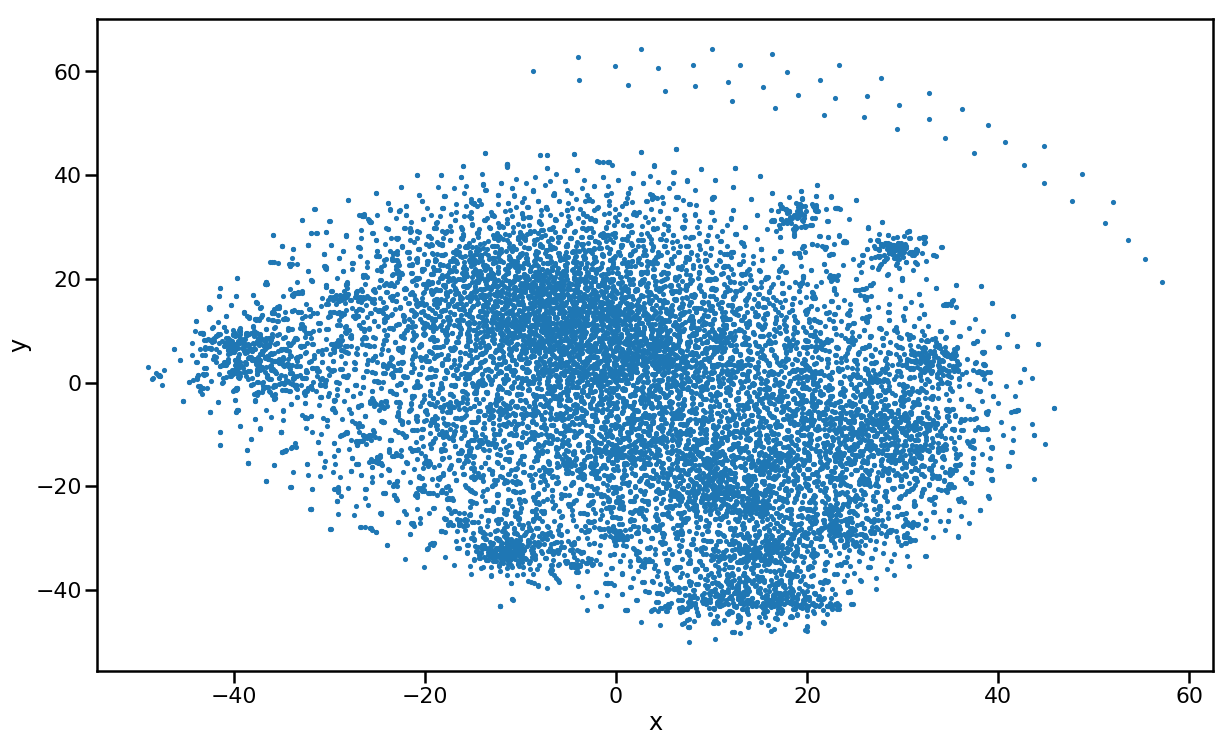

In [19]:
points = pd.DataFrame({
    "word":[word for word in thrones2vec.wv.vocab],
    "x":all_word_matrix_2d[:,0],
    "y":all_word_matrix_2d[:,1]
})
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
points.head(5)

### Explore semantic similarities between book characters

## uses cosine similarity to find similar words

In [20]:
thrones2vec.wv.most_similar("stark")

[('eddard', 0.6009404063224792),
 ('snowbeard', 0.4654235243797302),
 ('accommodating', 0.46405118703842163),
 ('divulge', 0.4528692960739136),
 ('edrick', 0.43332362174987793),
 ('interred', 0.4253771901130676),
 ('executed', 0.42412883043289185),
 ('winterfell', 0.4224868416786194),
 ('shirei', 0.4207403063774109),
 ('absently', 0.419999361038208)]

In [21]:
thrones2vec.wv.most_similar("aerys")

[('ii', 0.5084055662155151),
 ('jaehaerys', 0.5008337497711182),
 ('hollards', 0.4528576731681824),
 ('v', 0.4404420554637909),
 ('maekar', 0.4320008158683777),
 ('conciliator', 0.42534762620925903),
 ('relations', 0.4102381467819214),
 ('dated', 0.4060315191745758),
 ('spite', 0.40290799736976624),
 ('targaryen', 0.3980655372142792)]

In [22]:
thrones2vec.wv.most_similar("viserion")

[('rhaegal', 0.6650404930114746),
 ('drogon', 0.559409499168396),
 ('dracarys', 0.4707850515842438),
 ('lintel', 0.4266379773616791),
 ('harghaz', 0.4236982464790344),
 ('lazily', 0.42289426922798157),
 ('maw', 0.4224401116371155),
 ('scanned', 0.4142286777496338),
 ('unfolding', 0.4139035642147064),
 ('widening', 0.4113130569458008)]

In [23]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [24]:
nearest_similarity_cosmul("stark", "winterfell", "riverrun")
nearest_similarity_cosmul("catelyn", "eddard", "robert")
nearest_similarity_cosmul("arya", "nymeria", "drogon")

stark is related to winterfell, as tully is related to riverrun
catelyn is related to eddard, as cretin is related to robert
arya is related to nymeria, as dany is related to drogon


'dany'

In [25]:
nearest_similarity_cosmul("jon","man","woman")
nearest_similarity_cosmul("arya","stark","targaryen")

jon is related to man, as val is related to woman
arya is related to stark, as viserys is related to targaryen


'viserys'